In [11]:
########################################
#LIBRARIES
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import time
import pydde as dde
import matplotlib.pyplot as plt
import json
import os
import time

########################################
#PARAMETERS
print(time.strftime("%H%M"))
nTimeSteps = 60 #seconds
samplenum = 1000
epochs = 100
minibatch_size= 50
input_size = 9
hiddenlayers = [100]
learning_rate = 0.001
LRdecay = 0.7
use_case = 'qhold'
model_file_path = '../Trained_Models/'
sample_file_path = f'../Data/Samples/data_{use_case}_{nTimeSteps}tsteps_1535/'
simulation_file_path = '../Data/Simulations/pm_target.sim'
objective_file_path = f'../Data/Objectives/pm_qhold.obj'

# set log level
dde.set_log_level(dde.LogLevel.off)

#######################################
# LOAD SIMULATION AND OBJECTIVE FUNCTION
dyn = dde.DynamicSequence()
dyn.loadFile(simulation_file_path, nTimeSteps)
p_init = np.zeros(dyn.p0.size*nTimeSteps)
for i in range(0,nTimeSteps):
	p_init[i*dyn.p0.size : (i+1)*dyn.p0.size] = dyn.p0
state_init = dyn.q(p_init)
r = dyn.r(state_init, p_init)
dr = dyn.dr_dp(state_init, p_init)
dq = dyn.dq_dp(state_init, p_init)

# Objective Function
obj = dde.InverseObjective(dyn)
obj.loadFile(objective_file_path)
objective_json = json.load(open(objective_file_path))
opt = dde.Newton()

#########################################
#LOAD TRAINING SAMPLES
output_size = dyn.nParameters*nTimeSteps
'''
number_of_files = len(os.listdir(sample_file_path))-4
samplenum = 1000*number_of_files
output_size = dyn.nParameters*nTimeSteps

input = np.zeros((samplenum, input_size))

for filenum in range(number_of_files):
    with open(sample_file_path + f'data_{filenum}.json') as json_file:
        data = json.load(json_file)
        filesize = len(data['q'])
        for i, q_i in enumerate(data['q']):
            input[filenum*filesize+i, 0:3] = np.array(q_i)
        for i, qdot_i in enumerate(data['qdot']):
            input[filenum*filesize+i, 3:6] = np.array(qdot_i)
        for i, qddot_i in enumerate(data['qddot']):
            input[filenum*filesize+i, 6:9] = np.array(qddot_i)
        for i, p_now_i in enumerate(data['p_now']):
            input[filenum*filesize+i, 9:12] = np.array(p_now_i)
'''
input = np.zeros((samplenum,input_size))
# sample q
input[:,0] = np.random.rand(samplenum)
input[:,1] = np.random.rand(samplenum)
input[:,2] = np.random.rand(samplenum)
# sample qdot
input[:,3] = np.random.rand(samplenum)
input[:,4] = np.random.rand(samplenum)
input[:,5] = np.random.rand(samplenum)
# sample p_now
input[:,6] = np.random.rand(samplenum)*2
input[:,7] = np.random.rand(samplenum)*2
input[:,8] = np.random.rand(samplenum)*2

q_truth = np.zeros((samplenum, dyn.nDofs*nTimeSteps))
for i in range(samplenum):
    for k in range(nTimeSteps):
	    q_truth[i, k*dyn.nDofs : (k+1)*dyn.nDofs] = input[i, 0:3]
#Remove zeros
input = input[~(input == 0).all(1)]
print(f'Shape of data: {input}')
print(f'Shape of q_truth: {q_truth.shape}')

# Splitting the dataset into the Training set and Test set
#from sklearn.model_selection import train_test_split
#y_train, y_test, p_train, p_test = train_test_split(y_target, p, test_size = testsize)

#y_target = torch.tensor(y_train).float()
#p = torch.tensor(p_train).float()
input = torch.tensor(input).float()
q_truth = torch.tensor(q_truth).float()
#y_test = torch.tensor(y_test).float()
#p_test = torch.tensor(p_test).float()

1404
Shape of data: [[0.80831205 0.92047092 0.82246914 ... 1.47006722 1.61999309 0.5800891 ]
 [0.83304993 0.0223819  0.88415764 ... 0.58794278 1.87366503 1.34243127]
 [0.64207523 0.65021368 0.07324802 ... 0.36104754 1.31378128 1.37513691]
 ...
 [0.30298968 0.99884174 0.42587661 ... 0.42878354 1.02190641 0.10108358]
 [0.42854488 0.88388977 0.4111767  ... 0.20095836 1.63156673 0.42364254]
 [0.69329096 0.86573213 0.17663546 ... 0.39279736 0.18204655 0.4769581 ]]
Shape of q_truth: (1000, 180)


In [12]:
##########################################
#BUILD CUSTOM SIMULATION FUNCTION
class Simulate(torch.autograd.Function):
    
    @staticmethod
    def forward(ctx, input, data_input):
        #print(f'input: {input.shape}')
        p = input.detach().clone().numpy().transpose()
        q_pred = torch.ones([len(p[0, :]),dyn.nParameters*nTimeSteps])
        for i in range(len(p[0, :])):
            #dyn.q0 = data_input[i, 0:3]
            #dyn.qdot0 = data_input[i, 3:6]
            state = dyn.q(p[:,i], data_input[i, 0:3], data_input[i, 3:6])
            q_pred[i, :] = torch.tensor(state.q)
        #print(f'q_pred: {q_pred.shape}')
        
        ctx.save_for_backward(input, data_input)
        
        return q_pred
        
    @staticmethod
    def backward(ctx, grad_output):
        #print(grad_output)
        input, data_input = ctx.saved_tensors
        p = input.detach().clone().numpy().transpose()
        dq_dp_batch = torch.zeros([dyn.nDofs*nTimeSteps, dyn.nParameters*nTimeSteps])
        for i in range(len(p[0, :])):
            dyn.q0 = data_input[i, 0:3]
            dyn.qdot0 = data_input[i, 3:6]
            dyn.qddot0 = data_input[i, 6:9]
            state = dyn.q(p[:, i])
            dq_dp = dyn.dq_dp(state, p[:, i])
            dq_dp = torch.tensor(dq_dp)
            dq_dp_batch = dq_dp_batch + dq_dp
        #print(f'dq/dp_batch: {dy_dp_batch/samplenum}')
        
        grad_input = grad_output.mm(dq_dp_batch.float()/len(p[0,:]))
        #print(f'shape of grad input: {grad_input.shape}')
        #print(f'shape of grad output: {grad_output.shape}')
        return grad_input, None

Simulate = Simulate.apply

########################################
#BUILD CUSTOM MODEL
class ActiveLearn(nn.Module):

    def __init__(self, n_in, out_sz):
        super(ActiveLearn, self).__init__()

        self.L_in = nn.Linear(n_in, hiddenlayers[0])
        self.H1 = nn.Linear(hiddenlayers[0], 3*nTimeSteps)
        self.L_out = nn.Linear(3*nTimeSteps, 3*nTimeSteps)
        self.Relu = nn.ReLU(inplace=True)
        self.drop = nn.Dropout(p=0.5)
    
    def forward(self, input):
        x = self.L_in(input)
        x = self.Relu(x)
        x = self.H1(x)
        x = self.Relu(x)
        x = self.L_out(x)
        return x

model = ActiveLearn(input_size, output_size)

criterion = nn.SmoothL1Loss()  # RMSE = np.sqrt(MSE)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
scheduler= torch.optim.lr_scheduler.StepLR(optimizer, step_size = 15, gamma=LRdecay, last_epoch=-1)
print("done")

done


In [13]:
####################################################
#TRAIN THE MODEL
torch.autograd.set_detect_anomaly(True)

start_time = time.time()
weight_c1 = 1 # q error
weight_c2 = 1 # p start condition
weight_c3 = 1 # p smoothness condition
weight_c4 = 100 # p smoothness condition
batch = np.floor(samplenum/minibatch_size).astype(int)
losses= []
smoothness_errors_p = []
smoothness_errors_q = []
p_start_errors = []
q_errors = [] #q_end error
for e in range(epochs):
    for b in range(batch):
        input_b = input[b*minibatch_size:b*minibatch_size+minibatch_size,:]
        p_b = model(input_b)
        q_pred = Simulate(p_b, input_b)
        #smoothness_error_i = weight_c3*(p_i[0:3*(nTimeSteps-1)] - p_i[3:3*nTimeSteps]).pow(2).sum()
        smoothness_error_p = weight_c3*criterion(p_b[:, 0:dyn.nParameters*(nTimeSteps-1)], p_b[:, dyn.nParameters:dyn.nParameters*nTimeSteps])
        smoothness_error_q = weight_c4*criterion(q_pred[:, 0:dyn.nDofs*(nTimeSteps-1)], q_pred[:, dyn.nDofs:dyn.nDofs*nTimeSteps])
        #p_start_error = weight_c2*torch.sqrt(criterion(p_i[0:3], torch.tensor(dyn.p_init[0:3])))
        p_start_error = weight_c2*criterion(p_b[:, 0:dyn.nParameters], input_b[:,6:9])
        #q_end_error = torch.sqrt(criterion(q_pred, q_i))
        q_error = weight_c1*criterion(q_pred, q_truth[b*minibatch_size:b*minibatch_size+minibatch_size,:])
        loss = q_error + p_start_error + smoothness_error_p + smoothness_error_q
        #loss = loss_batch/minibatch_size
        losses.append(loss)
        #smoothness_error = smoothness_error_batch/minibatch_size
        smoothness_errors_p.append(smoothness_error_p)
        smoothness_errors_q.append(smoothness_error_q)
        q_errors.append(q_error)
        p_start_errors.append(p_start_error)
        optimizer.zero_grad()
        #Backpropagation
        loss.backward()
        optimizer.step()
    if e%(epochs/10) == 0:
        print(f'epoch: {e:3}/{epochs}  loss: {loss.item():10.8f}   basic_loss: {q_error.item():10.8f}')

print(f'epoch: {e:3} finale loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {(time.time() - start_time)/60:.3f} min') # print the time elapsed

epoch:   0/100  loss: 0.30296272   basic_loss: 0.11706410
epoch:  10/100  loss: 0.01010370   basic_loss: 0.00379163
epoch:  20/100  loss: 0.00750774   basic_loss: 0.00224099
epoch:  30/100  loss: 0.00697839   basic_loss: 0.00195590
epoch:  40/100  loss: 0.00670321   basic_loss: 0.00182451
epoch:  50/100  loss: 0.00653173   basic_loss: 0.00171847
epoch:  60/100  loss: 0.00645944   basic_loss: 0.00170224
epoch:  70/100  loss: 0.00636773   basic_loss: 0.00161743
epoch:  80/100  loss: 0.00628857   basic_loss: 0.00154229
epoch:  90/100  loss: 0.00620325   basic_loss: 0.00144993
epoch:  99 finale loss: 0.00615462

Duration: 16.552 min


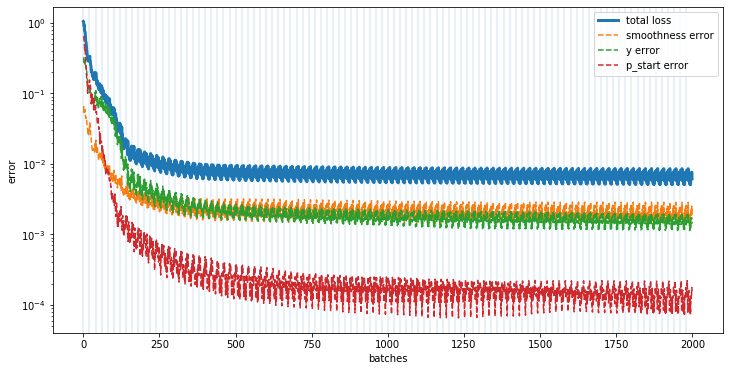

In [14]:
##################################################
#PLOT EVERY LOSS COMPONENT FOR EACH BATCH
timestr = time.strftime("%m%d")
epoch_lines = np.arange(0, epochs*batch, batch)
plt.figure(figsize = [12,6])
loss = plt.plot(losses, label = 'total loss', linewidth=3)
smoothness = plt.plot(smoothness_errors_q, label = 'smoothness error', linestyle='--')
q_end = plt.plot(q_errors, label = 'y error', linestyle='--')
p_start = plt.plot(p_start_errors, label = 'p_start error', linestyle='--')
plt.legend()
plt.yscale('log')
plt.ylabel('error')
plt.xlabel('batches')
for xc in epoch_lines:
    plt.axvline(x=xc, linewidth = 0.2)
plt.savefig('../Plots/Loss_' + use_case + '_' + timestr + '.png')
plt.show()

In [15]:
#####################################################
#SAVE MODEL
timestr = time.strftime("%m%d")
#Save entire Model
torch.save(model, model_file_path + 'Model_active_' + use_case + f'_{nTimeSteps}tsteps_{samplenum}s_{epochs}e_{LRdecay}lr_' + timestr + '.pt')
torch.save(model, model_file_path + 'Model_active_' + use_case + f'_{nTimeSteps}tsteps_latest.pt')

#Save parameters of Model
torch.save(model.state_dict(), model_file_path + 'state_dict/Trained_Model_statedict_active_' + use_case + f'_{nTimeSteps}tsteps_{samplenum}s_{epochs}e_{LRdecay}lr_' + timestr + '.pt')
torch.save(model.state_dict(), model_file_path + 'state_dict/Model_statedict_active_' + use_case + f'_{nTimeSteps}tsteps_latest.pt')

#Convert to Torch Script and save for CPP application
input_example = input[4, :]
traced_script_module = torch.jit.trace(model, input_example)

# Test the torch script
#test_input = torch.tensor([0, 2, 0.5])
#original = model(test_input)
#output_example = traced_script_module(test_input)

traced_script_module.save(model_file_path + 'Serialized_Models/Serialized_model_active_' + use_case + f'_{nTimeSteps}tsteps_latest.pt')
traced_script_module.save(model_file_path + 'Serialized_Models/Serialized_model_active_' + use_case + f'_{nTimeSteps}tsteps_{samplenum}s_{epochs}e_{LRdecay}lr_' + timestr + '.pt')
print('Model saved')

Model saved


## Test forward propagation

In [15]:
y_target_test= torch.tensor([0, 2, 0.5])
p = model(y_target_test)
y_pred = Simulate(p)
y_target = y_target_test.detach().numpy()
p = p.detach().numpy()


yTraj_test = dyn.compute(p)

print(yTraj_test.y)
print(np.sum(yTraj_test.y[-3:]-y_target))
print(p)

[ 7.06265214e-05  1.94512096e+00 -2.41065371e-03  3.31315787e-05
  1.92802432e+00 -1.53361098e-03 -2.50241846e-05  1.92932236e+00
  1.56063603e-03 -9.71003644e-05  1.93428661e+00  5.38268862e-03
 -1.62618436e-04  1.93360197e+00  8.86586868e-03 -2.25301555e-04
  1.93395067e+00  1.28316244e-02 -2.85834693e-04  1.93429806e+00
  1.71687823e-02 -3.50448650e-04  1.93525816e+00  2.19732797e-02
 -4.14815980e-04  1.93375367e+00  2.68146188e-02 -4.72172313e-04
  1.93669103e+00  3.27430476e-02 -5.28714245e-04  1.93759710e+00
  3.87745118e-02 -5.78609289e-04  1.93827448e+00  4.51808948e-02
 -6.33160244e-04  1.94006216e+00  5.21617538e-02 -6.88252925e-04
  1.93954718e+00  5.92062964e-02 -7.34688687e-04  1.94146587e+00
  6.70216432e-02 -7.42094754e-04  1.94816654e+00  7.59523267e-02
 -7.49759755e-04  1.95197583e+00  8.48596589e-02 -7.56351785e-04
  1.95427444e+00  9.39290308e-02 -7.62178840e-04  1.95308895e+00
  1.02900194e-01 -7.64573918e-04  1.95149467e+00  1.12150193e-01
 -7.47805104e-04  1.95606